In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
#import ratingSOM
#from ratingSOM import SOM
from PIL import Image

In [2]:
"""
Script to implement simple self organizing map using PyTorch, with methods
similar to clustering method in sklearn.
@author: Riley Smith
Created: 1-27-21
"""



class SOM():
    """
    The 2-D, rectangular grid self-organizing map class using Numpy.
    """
    def __init__(self, m=3, n=3, dim=3, lr=1, sigma=1, max_iter=3000,
                    random_state=None, som_type="normal", alpha=0.5, use_triangular=False, use_prob_candidate_selection = False):
        """
        Parameters
        ----------
        m : int, default=3
            The shape along dimension 0 (vertical) of the SOM.
        n : int, default=3
            The shape along dimesnion 1 (horizontal) of the SOM.
        dim : int, default=3
            The dimensionality (number of features) of the input space.
        lr : float, default=1
            The initial step size for updating the SOM weights.
        sigma : float, optional
            Optional parameter for magnitude of change to each weight. Does not
            update over training (as does learning rate). Higher values mean
            more aggressive updates to weights.
        max_iter : int, optional
            Optional parameter to stop training if you reach this many
            interation.
        random_state : int, optional
            Optional integer seed to the random number generator for weight
            initialization. This will be used to create a new instance of Numpy's
            default random number generator (it will not call np.random.seed()).
            Specify an integer for deterministic results.
        som_type : string, optional
            Options to determine whether classical (normal), rating-aware (rating), rank-aware (rank), or rank aware
            with positional discounts (rank_pos) SOM is performed
        alpha: float, optional
            Hyperparameter to tune importance of ranking vs. local similarity. 
            Higher alpha values denote more importance to the local similarity (original SOM)
        use_triangular: bool, optional
            Determine the ranking of displayed grid coordinates: row-first bases (False) 
            or triangular starting from top-left corner (True)    
        use_prob_candidate_selection: bool, optional
            For each epoch, candidates are either selected uniformly (False) or based on probability distribution (True)
            Probability distribution is supposed to be induced by the rating of individual candidates
            (better rating => higher probability to affect SOM composition)
        """
        # Initialize descriptive features of SOM
        self.m = m
        self.n = n
        self.dim = dim
        self.shape = (m, n)
        self.initial_lr = lr
        self.lr = lr
        self.sigma = sigma
        self.max_iter = max_iter

        
        #initialize rankingSOM specific features
        self.som_type = som_type
        self.alpha = alpha
        self.use_triangular = use_triangular
        self.use_prob_candidate_selection = use_prob_candidate_selection
        self.triangular_ordering = self._get_golden_triangle_ordering(m).reshape(-1)

        # Initialize weights
        self.random_state = random_state
        rng = np.random.default_rng(random_state)
        self.weights = rng.normal(size=(m * n, dim))
        self._locations = self._get_locations(m, n)

        # Set after fitting
        self._inertia = None
        self._n_iter_ = None
        self._trained = False
        
        
    def _get_golden_triangle_ordering(self, size):
        #get ordering of the golden triangle starting from top-left corner and going over second diagonal.
        #having a 3x3 square, the ordering is [0,0], [0,1], [1,0], [0,2], [1,1], [2,0], [1,2], [2,1], [2,2]
        #only works for squares (extension for rectangles plausible TODO)
        maxIndexSum = size*2 -1
        listOfIndices = []

        for n in range(maxIndexSum):
            for i in range(size):
                firstIndex = i
                secondIndex = n-i
                if secondIndex < size and secondIndex >= 0:
                    listOfIndices.append((firstIndex,secondIndex))


        mat = np.zeros((size,size),dtype=int)   
        vals = np.array(range(size**2))

        for i,idx in enumerate(listOfIndices):
            mat[idx] = vals[i]
        return mat


    def _get_locations(self, m, n):
        """
        Return the indices of an m by n array.
        """
        return np.argwhere(np.ones(shape=(m, n))).astype(np.int64)

    def _find_bmu(self, x):
        """
        Find the index of the best matching unit for the input vector x.
        """
        # Stack x to have one row per weight
        x_stack = np.stack([x]*(self.m*self.n), axis=0)
        # Calculate distance between x and each weight
        distance = np.linalg.norm(x_stack - self.weights, axis=1)
        # Find index of best matching unit
        return np.argmin(distance)

    def _find_bmu_rank_aware(self, x, rank, rating):
        """
        Consider ranking of individual cases
        Directly optimizing Kendall Tau coefficient
        Approximative normalization due to comparability between both distance metrics
        Possible problem: too small difference of rank-aware distances if m*n is small compared to total volume of samples
        """
        # Stack x to have one row per weight
        x_stack = np.stack([x]*(self.m*self.n), axis=0)
        # Calculate distance between x and each weight
        distance = np.linalg.norm(x_stack - self.weights, axis=1)
        # Find index of best matching unit
        
        x_rank_stack = np.array([rank+1]*(self.m*self.n))
        
        # Use row-wise or left-top triangular ordering of grid
        if self.use_triangular == True:
            nodes_rank = self.triangular_ordering+1
        else:            
            nodes_rank = np.array(range((self.m*self.n)))+1
        
        rankDistance = np.absolute(x_rank_stack-nodes_rank) / self.volume_of_samples
        
        finalDistance = self.alpha * distance + (1-self.alpha) * rankDistance
        return np.argmin(finalDistance)
    
    
    def _find_bmu_rank_aware_positional(self, x, rank, rating):
        """
        Consider ranking of individual cases
        Rather drastic increase in importance w.r.t. position of item (more important on top positions than later on)
        Does not optimize any well-known metric in particular, but may provide visually reasonable results
        """
        # Stack x to have one row per weight
        x_stack = np.stack([x]*(self.m*self.n), axis=0)
        # Calculate distance between x and each weight
        distance = np.linalg.norm(x_stack - self.weights, axis=1)
        # Find index of best matching unit
        
        x_rank_stack = np.array([rank+1]*(self.m*self.n))
        
        # Use row-wise or left-top triangular ordering of grid
        if self.use_triangular == True:
            nodes_rank = self.triangular_ordering+1
        else:            
            nodes_rank = np.array(range((self.m*self.n)))+1
        
        # the part of denominator self.volume_of_samples/(self.m*self.n) is not necessary
        # it is kept to normalize the results to the _find_bmu_rank_aware() function (the last node has the same penalty)
        rankDistance = np.absolute(x_rank_stack-nodes_rank) / (nodes_rank * self.volume_of_samples/(self.m*self.n))
        
        finalDistance = self.alpha * distance + (1-self.alpha) * rankDistance
        return np.argmin(finalDistance)
    
    
    def _find_bmu_rating_aware(self, x, rank, rating):
        """
        Consider ratings of individual cases
        Optimize piece-wise DCG (i.e., difference between expected relevance on this position and the actual one)
        Importance of the distance for particular field is weighted in the same way as in nDCG (1/log2(pos+1))
        """
        
        # Stack x to have one row per weight
        x_stack = np.stack([x]*(self.m*self.n), axis=0)
        # Calculate distance between x and each weight
        distance = np.linalg.norm(x_stack - self.weights, axis=1)
        # Find index of best matching unit
        
        x_rating_stack = np.array([rating]*(self.m*self.n))   
        
        # Use row-wise or left-top triangular ordering of grid
        if self.use_triangular == True:
            nodes_rank = self.triangular_ordering+1
        else:            
            nodes_rank = np.array(range((self.m*self.n)))+1
            
        rankBasedWeights = 1/np.log2(nodes_rank+1)       
        rankDistance = rankBasedWeights * np.absolute(x_rating_stack-self.expected_ratings)
        
        finalDistance = self.alpha * distance + (1-self.alpha) * rankDistance
        return np.argmin(finalDistance)
        
    
    def step(self, x, rank, rating):
        """
        Do one step of training on the given input vector.
        """
        # Stack x to have one row per weight
        x_stack = np.stack([x]*(self.m*self.n), axis=0)

        # Get index of best matching unit
        # Based on the SOM type, different procedures are applied here
        # - this is the only difference between normal SOM and rank-aware SOM
        
        #classical (normal), rating-aware (rating), rank-aware (rank), or rank aware with positional discounts (rank_pos)
        if self.som_type == "normal":
            bmu_index = self._find_bmu(x)
        elif self.som_type == "rating":
            bmu_index = self._find_bmu_rating_aware(x, rank, rating)        
        elif self.som_type == "rank":
            bmu_index = self._find_bmu_rank_aware(x, rank, rating)
        elif self.som_type == "rank_pos":
            bmu_index = self._find_bmu_rank_aware_positional(x, rank, rating)            
            
        # Find location of best matching unit
        bmu_location = self._locations[bmu_index,:]

        # Find square distance from each weight to the BMU
        stacked_bmu = np.stack([bmu_location]*(self.m*self.n), axis=0)
        bmu_distance = np.sum(np.power(self._locations.astype(np.float64) - stacked_bmu.astype(np.float64), 2), axis=1)

        # Compute update neighborhood
        neighborhood = np.exp((bmu_distance / (self.sigma ** 2)) * -1)
        local_step = self.lr * neighborhood

        # Stack local step to be proper shape for update
        local_multiplier = np.stack([local_step]*(self.dim), axis=1)

        # Multiply by difference between input and weights
        delta = local_multiplier * (x_stack - self.weights)

        # Update weights
        self.weights += delta

    def _compute_point_intertia(self, x):
        """
        Compute the inertia of a single point. Inertia defined as squared distance
        from point to closest cluster center (BMU)
        """
        # Find BMU
        bmu_index = self._find_bmu(x)
        bmu = self.weights[bmu_index]
        # Compute sum of squared distance (just euclidean distance) from x to bmu
        return np.sum(np.square(x - bmu))

    def fit(self, X, ranks, ratings, epochs=1, shuffle=True):
        """
        Take data (a tensor of type float64) as input and fit the SOM to that
        data for the specified number of epochs.
        Parameters
        ----------
        X : ndarray
            Training data. Must have shape (n, self.dim) where n is the number
            of training samples.
        ranks: ndarray
            Ranks of the training data w.r.t. original ordering
        ratings: ndarray
            Ratings of the training data w.r.t. original ordering
        epochs : int, default=1
            The number of times to loop through the training data when fitting.
        shuffle : bool, default True
            Whether or not to randomize the order of train data when fitting.
            Can be seeded with np.random.seed() prior to calling fit.
        Returns
        -------
        None
            Fits the SOM to the given data but does not return anything.
        """
        topK = np.argsort(ranks)[:(self.m*self.n)]
        self.expected_ratings = ratings[topK]
        self.volume_of_samples = len(X)
        
        # Count total number of iterations
        global_iter_counter = 0
        n_samples = X.shape[0]
        total_iterations = np.minimum(epochs * n_samples, self.max_iter)
        
        #prepare for probabilistic candidates selection
        rngForCandidateSelection = np.random.default_rng(self.random_state)
        prob = ratings/np.sum(ratings)
        
        for epoch in range(epochs):
            # Break if past max number of iterations
            if global_iter_counter > self.max_iter:
                break
            
            if self.use_prob_candidate_selection:
                indices = rngForCandidateSelection.choice(np.arange(n_samples) , size=n_samples, p=prob)             
            elif shuffle:
                rng = np.random.default_rng(self.random_state)
                indices = rng.permutation(n_samples)
            else:
                indices = np.arange(n_samples)

            # Train
            for idx in indices:
                # Break if past max number of iterations
                if global_iter_counter > self.max_iter:
                    break
                input = X[idx]
                rank = ranks[idx]
                rating = ratings[idx]
                # Do one step of training
                self.step(input, rank, rating)
                # Update learning rate
                global_iter_counter += 1
                self.lr = (1 - (global_iter_counter / total_iterations)) * self.initial_lr

        # Compute inertia
        inertia = np.sum(np.array([float(self._compute_point_intertia(x)) for x in X]))
        self._inertia_ = inertia

        # Set n_iter_ attribute
        self._n_iter_ = global_iter_counter

        # Set trained flag
        self._trained = True

        return

    def predict(self, X, ranks, ratings):
        """
        Predict cluster for each element in X.
        Parameters
        ----------
        X : ndarray
            An ndarray of shape (n, self.dim) where n is the number of samples.
            The data to predict clusters for.
        Returns
        -------
        labels : ndarray
            An ndarray of shape (n,). The predicted cluster index for each item
            in X.
        """
        # Check to make sure SOM has been fit
        if not self._trained:
            raise NotImplementedError('SOM object has no predict() method until after calling fit().')

        # Make sure X has proper shape
        assert len(X.shape) == 2, f'X should have two dimensions, not {len(X.shape)}'
        assert X.shape[1] == self.dim, f'This SOM has dimesnion {self.dim}. Received input with dimension {X.shape[1]}'
        
        
        indices = range(len(ranks))
        labels = np.array([self._find_bmu(X[idx,:]) for idx in indices])
        #if self.som_type == "normal":
        #    labels = np.array([self._find_bmu(X[idx,:]) for idx in indices])
        #elif self.som_type == "rank":
        #    labels = np.array([self._find_bmu_rank_aware(X[idx,:], ranks[idx], ratings[idx]) for idx in indices])

        return labels

    def transform(self, X, ranks, ratings):
        """
        Transform the data X into cluster distance space.
        Parameters
        ----------
        X : ndarray
            Data of shape (n, self.dim) where n is the number of samples. The
            data to transform.
        Returns
        -------
        transformed : ndarray
            Transformed data of shape (n, self.n*self.m). The Euclidean distance
            from each item in X to each cluster center.
        """
        # Stack data and cluster centers
        X_stack = np.stack([X]*(self.m*self.n), axis=1)
        cluster_stack = np.stack([self.weights]*X.shape[0], axis=0)

        # Compute difference
        diff = X_stack - cluster_stack

        # Take and return norm
        return np.linalg.norm(diff, axis=2)

    @property
    def cluster_centers_(self):
        return self.weights.reshape(self.m, self.n, self.dim)

    @property
    def inertia_(self):
        if self._inertia_ is None:
            raise AttributeError('SOM does not have inertia until after calling fit()')
        return self._inertia_

    @property
    def n_iter_(self):
        if self._n_iter_ is None:
            raise AttributeError('SOM does not have n_iter_ attribute until after calling fit()')
        return self._n_iter_

### Loading dataset
- 20000 keyframes as in https://dl.acm.org/doi/10.1145/3372278.3390726

In [3]:
filepaths = pd.read_csv("native-queries/frame-ID-to-filepath.csv",sep=' ',names=['filename', 'ID'])
filepathsArray = filepaths.filename.to_numpy()

query_scores = np.fromfile("native-queries/native-query-scores.bin", dtype='f')
query_scores = query_scores.reshape(327, 20000)

frame_ids = np.fromfile("native-queries/native-query-frame-IDs.bin", dtype='i')
frame_ids = frame_ids.reshape(327, 20000)

frame_features = np.fromfile("native-queries/frame-features.bin", dtype='f')
frame_features = frame_features.reshape(20000, 128)

nativeQueries = pd.read_csv("native-queries/native-queries.csv",sep=';',header=0)

(array([3.140000e+02, 3.512000e+03, 2.405700e+04, 2.377660e+05,
        1.383429e+06, 8.012490e+05, 9.448200e+04, 1.257700e+04,
        1.978000e+03, 6.360000e+02]),
 array([-0.59903127, -0.47379982, -0.34856838, -0.22333695, -0.09810551,
         0.02712592,  0.15235737,  0.2775888 ,  0.40282023,  0.5280517 ,
         0.6532831 ], dtype=float32),
 <BarContainer object of 10 artists>)

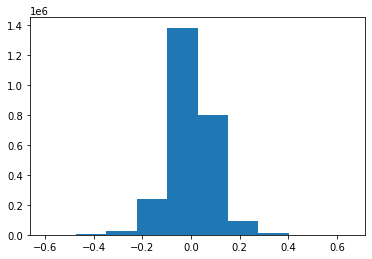

In [4]:
plt.hist(frame_features.reshape(-1))

In [5]:
def getGoldenTriangleOrdering(size):
    #get ordering of the golden triangle starting from top-left corner and going over second diagonal.
    #having a 3x3 square, the ordering is [0,0], [0,1], [1,0], [0,2], [1,1], [2,0], [1,2], [2,1], [2,2]
    maxIndexSum = size*2 -1
    listOfIndices = []
    
    for n in range(maxIndexSum):
        for i in range(size):
            firstIndex = i
            secondIndex = n-i
            if secondIndex < size and secondIndex >= 0:
                listOfIndices.append((firstIndex,secondIndex))
    
 
    mat = np.zeros((size,size),dtype=int)   
    vals = np.array(range(size**2))

    for i,idx in enumerate(listOfIndices):
        mat[idx] = vals[i]
    return mat
indexMatrix = getGoldenTriangleOrdering(8)
indexMatrix.reshape(-1)

array([ 0,  1,  3,  6, 10, 15, 21, 28,  2,  4,  7, 11, 16, 22, 29, 36,  5,
        8, 12, 17, 23, 30, 37, 43,  9, 13, 18, 24, 31, 38, 44, 49, 14, 19,
       25, 32, 39, 45, 50, 54, 20, 26, 33, 40, 46, 51, 55, 58, 27, 34, 41,
       47, 52, 56, 59, 61, 35, 42, 48, 53, 57, 60, 62, 63])

In [6]:
class EvalProcessVBS():
    
    labels = {
        "normal":"Plain SOM",
        "rating":"Rating SOM",
        "rank":"Rank SOM",
        "rank_pos":"DiscRank SOM",
        "topk":"Top-K display",
        
    }
    
    def __init__(self, som_variants, alphas,  display_mode, exponents, examples, path_to_image,  
                 test_set_size, bias_std_dev, use_triangular):          
        self.SOM_dim = 8
        
        self.som_variants = som_variants
        self.alphas = alphas
        self.display_mode = display_mode
        self.exponents = exponents
        self.use_triangular = use_triangular
        self.bias_std_dev = bias_std_dev
        self.use_prob_candidate_selections = [False,True]        
         
        self.unbiasedSamples = examples
        self.path_to_image = path_to_image
        
        self.test_size = test_set_size

        
        np.random.seed(10)
        self.testTargetIDs = np.random.choice(self.unbiasedSamples.shape[0],self.test_size)
        self.testTargets = self.unbiasedSamples[self.testTargetIDs,:]     
        
        
    def _evaluateTestSampleRating(self):
        """
        evaluates rating and ranking between sample objects and test objects
        """

        np.random.seed(42)
        samples = self.unbiasedSamples
        
        self.pairwiseSampleDistances = euclidean_distances(samples) 
        unbiasedDistance = euclidean_distances(samples, self.testTargets) 
        
        self.unbiasedRatings = np.exp(-self.exponent*unbiasedDistance)
        #self.unbiasedRatings = ((2-unbiasedDistance)/2)**self.exponent
        
        if self.bias_std_dev >0:
            #bias = np.random.normal(0.0, self.bias_std_dev, size=self.unbiasedSamples.shape)
            #samples = self.unbiasedSamples+bias
        
            bias = np.random.normal(0.0, self.bias_std_dev, size=self.testTargets.shape)
            testTargets = self.testTargets+bias
            
        self.samples = samples #using biased samples to order stuf
        
        distance = euclidean_distances(samples, testTargets)        

        self.ratings = np.exp(-self.exponent*distance)
        self.ratings = self.ratings/np.max(self.ratings)
        #self.ratings = ((2-distance)/2)**self.exponent
        
        ranks = []
        temp = distance.argsort(axis=0)
        for i in range(self.test_size):
            rank = np.empty_like(temp[:,i])

            rank[temp[:,i]] = np.arange(distance.shape[0])
            ranks.append(rank)
        self.ranks = np.stack(ranks, axis=-1)
        
        
            
        
    def runConfigurations(self): 
        resultingIDX = {}
        ratings = {}
        ratingsUnbiased = {} 
        for e in self.exponents:
            self.exponent = e
            # calculate rating and ranking for individual test cases and sample data
            self._evaluateTestSampleRating()
            
            for a in self.alphas:
                print("alpha: "+str(a)+" exponent:"+str(e))
                for i in range(self.test_size):
                    if i%10 == 0:
                        print("test-case: "+str(i))
                    for pcs in self.use_prob_candidate_selections:                    
                        self.use_prob_candidate_selection = pcs
                        numOfVariants = len(self.som_variants)

                        for idx,sv in enumerate(self.som_variants):
                            if a > self.alphas[0] and (sv == "normal" or sv =="topk"):
                                continue #run plain som and topk only once
                            if e != self.exponents[2] and pcs == False:
                                continue # only one variant of exponent for non-probabilistic approaches

                            (displayedIDXs,displayedRatings,displayedUnbiasedRatings) = self.runOneStep(a, sv, i)
                            resultingIDX[(a,i,sv,e,self.display_mode,self.use_triangular,self.use_prob_candidate_selection)] = displayedIDXs
                            ratings[(a,i,sv,e,self.display_mode,self.use_triangular,self.use_prob_candidate_selection)] = displayedRatings
                            ratingsUnbiased[(a,i,sv,e,self.display_mode,self.use_triangular,self.use_prob_candidate_selection)] = displayedUnbiasedRatings


        return (resultingIDX,ratings,ratingsUnbiased)
              
            
    def runOneStep(self, alpha, som_variant, testIndex):  
        #fig,ax = plt.subplots(1,1)
        #testPath = self.path_to_image[self.testTargetIDs[testIndex]]
        #self.displayOneElement(ax, testPath) 
        
        #print(alpha, som_variant, testIndex, self.use_prob_candidate_selection)
        if self.display_mode == "topk":   
            if som_variant == "topk":
                (displayedIDXs,displayedRatings) = self.displayTopKForTopK(
                    self.testTargets[testIndex], self.ratings[:,testIndex], 
                    self.ranks[:,testIndex], som_variant, alpha, self.use_triangular, self.use_prob_candidate_selection)   
            else:
                (displayedIDXs,displayedRatings) = self.displayTopKForRankSOM(
                    self.testTargets[testIndex], self.ratings[:,testIndex], 
                    self.ranks[:,testIndex], som_variant, alpha, self.use_triangular, self.use_prob_candidate_selection)
                
            displayedUnbiasedRatings = self.unbiasedRatings[displayedIDXs,testIndex]                   
            
        return (displayedIDXs,displayedRatings,displayedUnbiasedRatings)
     
        

    def displayOneElement(self, ax, path):
        directory = "native-queries/thumbs/"
        img = Image.open(directory + path)
        img = img.resize((128, 72))
        img = np.asarray(img)
        ax.imshow(img)
        self.finalizeImage(ax) 
        
    
    def finalizeImage(self, ax):
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.margins(0.0)
        ax.set_xticks(())
        ax.set_yticks(())
        
    def displayTopKForRankSOM(self, target, ratings, rankings, som_type, alpha, use_triangular, use_prob_candidate_selection):
        
        vbs_som = SOM(m=self.SOM_dim, n=self.SOM_dim, dim=128, random_state=42, max_iter=40000, 
                        som_type=som_type, alpha=alpha, use_triangular=use_triangular, 
                        use_prob_candidate_selection = use_prob_candidate_selection)        
        vbs_som.fit(self.samples, rankings, ratings, epochs=10)
        
        linearized_indexes = vbs_som.predict(self.samples, rankings, ratings)
        indexes = np.unravel_index(linearized_indexes,(self.SOM_dim,self.SOM_dim))
        
        allGridPositions = np.arange(self.SOM_dim**2)
        
        idxToDisplay = []
        for i in allGridPositions:
            clusterGroup = (linearized_indexes == i).nonzero()[0]
            clusterGroup = [i for i in clusterGroup if i not in idxToDisplay]
            if len(clusterGroup) > 0:     
                #non-empty cluster, get top-k element
                idx = np.arange(ratings.size)[clusterGroup]
                idxToDisplay.append(idx[np.argmax(ratings[idx])])
            else:
                #empty cluster, finding closest not yet used image to the cluster centre
                clusterCentre = vbs_som.weights[i]
                distanceToClusterCentre = euclidean_distances(self.samples, clusterCentre.reshape(-1,128)).reshape(-1)
                sortedDistances = np.argsort(distanceToClusterCentre) 
                sortedDistances = [i for i in sortedDistances if i not in idxToDisplay]
                idxToDisplay.append(sortedDistances[0])
        #print(np.unique(idxToDisplay).shape)
        
        displayedIDXs = []
        displayedRatings = []
        
        #fig,ax= plt.subplots(self.SOM_dim,self.SOM_dim, figsize=(self.SOM_dim*2,self.SOM_dim*2*0.5625))
        
        for i, idx in enumerate(idxToDisplay):
            #x = i // self.SOM_dim
            #y = i % self.SOM_dim 
            #pathToImage = self.path_to_image[idx]
            
            displayedIDXs.append(idx)
            displayedRatings.append(ratings[idx])
            
            #self.displayOneElement(ax[x, y], pathToImage) 
            
        #plt.tight_layout(pad=0.0)
        
        return displayedIDXs,displayedRatings        
        

        
    def displayTopKForTopK(self, target, ratings, rankings, som_type, alpha, use_triangular, use_prob_candidate_selection):
        topkIndeces = np.argsort(rankings)[0:(self.SOM_dim*self.SOM_dim)]
        if use_triangular:
            ordering = getGoldenTriangleOrdering(self.SOM_dim).reshape(-1)
            topkIndeces = topkIndeces[ordering]        
        
        #fig,ax= plt.subplots(self.SOM_dim,self.SOM_dim, figsize=(self.SOM_dim*2,self.SOM_dim*2*0.5625))

        displayedIDXs = []
        displayedRanks = []
        displayedRatings = []
        
        for i,idx in enumerate(topkIndeces):
            #x = i // self.SOM_dim
            #y = i % self.SOM_dim            
            #pathToImage = self.path_to_image[idx]
            
            displayedIDXs.append(idx)
            displayedRatings.append(ratings[idx])

            #self.displayOneElement(ax[x, y], pathToImage)

        #plt.tight_layout(pad=0.0)
        
        return displayedIDXs,displayedRatings       

def processData(dataDict):
        resultsDF = pd.DataFrame.from_dict(dataDict, orient="index", columns=["r"+str(i) for i in list(range(1,65))])
        resultsDF.index = pd.MultiIndex.from_tuples(resultsDF.index, names=('alpha', 'item',"som_variant","exponent","display_mode","use_triangular","use_prob_candidate_selection"))
        resultsDF = resultsDF.reset_index()                        
        #resultsDF[list(range(1,65))] = pd.DataFrame(resultsDF.results.tolist(), index=resultsDF.index)
        #resultsDF.drop("results",axis=1, inplace=True)
        resultsDF["mean"] = resultsDF[["r"+str(i) for i in list(range(1,65))]].mean(axis=1)
        #print(resultsDF.groupby("som_variant")["mean"].mean())
        
        return resultsDF       
        

In [8]:
evalProc = EvalProcessVBS(["rating","normal","topk"], #,"rating","normal","topk""rank","rank_pos"
                       [0.0003, 0.001, 0.003], #[0.0001, 0.001, 0.003, 0.01, 0.03, 0.1, 0.2, 0.5, 0.8, 0.9], 3e-9, 1e-8, 3e-8, 1e-7, 3e-7, 1e-6, 3e-6, 1e-5, 3e-5
                       "topk", 
                       [5,20,10],#[5,20,10],
                       frame_features, 
                       filepathsArray,
                       100, 
                       0.2, 
                       True)
(resultingIDX,ratings,ratingsUnbiased) = evalProc.runConfigurations()

import pickle
ratingsDF = processData(ratings)
ratingsUnbDF = processData(ratingsUnbiased)
resultingIDXDF = processData(resultingIDX)

pickle.dump(evalProc,open("pck/evalProcVBSf3"+"_disp"+str(evalProc.display_mode)+"_triag"+str(evalProc.use_triangular)+".pck", "wb"))
ratingsDF.to_pickle("pck/ratingsDFVBSf3"+"_disp"+str(evalProc.display_mode)+"_triag"+str(evalProc.use_triangular)+".pck")
ratingsUnbDF.to_pickle("pck/ratingsUnbDFVBSf3"+"_disp"+str(evalProc.display_mode)+"_triag"+str(evalProc.use_triangular)+".pck")
resultingIDXDF.to_pickle("pck/resultingIDXDFVBSf3"+"_disp"+str(evalProc.display_mode)+"_triag"+str(evalProc.use_triangular)+".pck")

alpha: 0.0003 exponent:5
test-case: 0
test-case: 10
test-case: 20
test-case: 30
test-case: 40
test-case: 50
test-case: 60
test-case: 70
test-case: 80
test-case: 90
alpha: 0.001 exponent:5
test-case: 0
test-case: 10
test-case: 20
test-case: 30
test-case: 40
test-case: 50
test-case: 60
test-case: 70
test-case: 80
test-case: 90
alpha: 0.003 exponent:5
test-case: 0
test-case: 10
test-case: 20
test-case: 30
test-case: 40
test-case: 50
test-case: 60
test-case: 70
test-case: 80
test-case: 90
alpha: 0.0003 exponent:20
test-case: 0
test-case: 10
test-case: 20
test-case: 30
test-case: 40
test-case: 50
test-case: 60
test-case: 70
test-case: 80
test-case: 90
alpha: 0.001 exponent:20
test-case: 0
test-case: 10
test-case: 20
test-case: 30
test-case: 40
test-case: 50
test-case: 60
test-case: 70
test-case: 80
test-case: 90
alpha: 0.003 exponent:20
test-case: 0
test-case: 10
test-case: 20
test-case: 30
test-case: 40
test-case: 50
test-case: 60
test-case: 70
test-case: 80
test-case: 90
alpha: 0.0003 exp

In [24]:
import pickle
evalProc = pickle.load(open("pck/evalProcVBSf3_disptopk_triagTrue.pck", "rb"))
ratingsDF = pickle.load(open("pck/ratingsDFVBSf3_disptopk_triagTrue.pck", "rb"))
ratingsUnbDF = pickle.load(open("pck/ratingsUnbDFVBSf3_disptopk_triagTrue.pck", "rb"))
resultingIDXDF = pickle.load(open("pck/resultingIDXDFVBSf3_disptopk_triagTrue.pck", "rb"))

#evalProc = pickle.load(open("pck/evalProcVBS_disptopk_triagFalse.pck", "rb"))
#ratingsDF = pickle.load(open("pck/ratingsDFVBS_disptopk_triagFalse.pck", "rb"))
#ratingsUnbDF = pickle.load(open("pck/ratingsUnbDFVBS_disptopk_triagFalse.pck", "rb"))
#resultingIDXDF = pickle.load(open("pck/resultingIDXDFVBS_disptopk_triagFalse.pck", "rb"))

In [25]:
def calculateNDCG(idsDisplayed, ratingsAll, use_triangular, SOM_dim):
    DCGPenalty = 1/np.log2(np.array(range(SOM_dim**2))+2)
    if use_triangular:
        dcgOrdering = getGoldenTriangleOrdering(SOM_dim).reshape(-1)
        DCGPenalty = DCGPenalty[dcgOrdering]
    positions = ["r"+str(i) for i in list(range(1,SOM_dim**2+1))]    
    
    dataIdeal = ratingsAll[:,idsDisplayed.item].T
    topkIDX = np.argsort(-dataIdeal, axis=1)[:,0:SOM_dim**2]
    
    if use_triangular:
        topkIDX = topkIDX[:,dcgOrdering] 
        
    bestRatings = []
    for i in range(topkIDX.shape[0]):
        bestRatings.append(np.take(dataIdeal[i], topkIDX[i]))
    bestRatingsArr = np.stack(bestRatings) 
    
    
    ids = idsDisplayed[positions].to_numpy()
    receivedRatings = []
    for i in range(topkIDX.shape[0]):
        receivedRatings.append(np.take(dataIdeal[i], ids[i]))
    receivedRatings = np.stack(receivedRatings)     
    
    iDCG = np.sum(bestRatingsArr*DCGPenalty, axis=1)
    DCG = np.sum(receivedRatings*DCGPenalty, axis=1)
    nDCG = DCG/iDCG
    
    return nDCG

def calculateOverallDiversity(displayedIDX, distances, SOM_dim):
    positions = ["r"+str(i) for i in list(range(1,SOM_dim**2+1))]    
    
    data = displayedIDX[positions]
    df2 = pd.DataFrame(index=data.index)

    for i in range(data.shape[1]):
        for j in range(i+1,data.shape[1]):
            df2["d_"+str(i+1)+"_"+str(j+1)] = distances[data["r"+str(i+1)],data["r"+str(j+1)]]
    return df2.mean(axis=1),df2.max(axis=1) 

def neighbors(i, SOM_dim):
    minVal = 0
    maxVal = SOM_dim - 1
    vals = []
    ii = i // SOM_dim
    ij = i % SOM_dim
    for a in [-1,0,1]:
        for b in [-1,0,1]:
            if ii+a >= minVal and ij+b >= minVal and ii+a <= maxVal and ij+b <= maxVal:
                val = (ii+a)*SOM_dim + ij+b
                if val != i:
                    vals.append(val) 
    return vals
            

def calculateNeighborsDiversity(displayedIDX, distances, SOM_dim):
    positions = ["r"+str(i) for i in list(range(1,SOM_dim**2+1))]    
    
    data = displayedIDX[positions]
    df2 = pd.DataFrame(index=data.index)

    for i in range(data.shape[1]):
        for j in neighbors(i,SOM_dim):
            #print(i,j)
            df2["d_"+str(i+1)+"_"+str(j+1)] = distances[data["r"+str(i+1)],data["r"+str(j+1)]]
    return df2.mean(axis=1),df2.max(axis=1) 

In [26]:
meanDistN, maxDistN = calculateNeighborsDiversity(resultingIDXDF, evalProc.pairwiseSampleDistances, evalProc.SOM_dim)
resultingIDXDF["meanNeighborDiversity"]  =  meanDistN 
resultingIDXDF["maxNeighborDiversity"]  =  maxDistN 
meanDist, maxDist = calculateOverallDiversity(resultingIDXDF, evalProc.pairwiseSampleDistances, evalProc.SOM_dim)
resultingIDXDF["meanOverallDiversity"]  =  meanDist 
resultingIDXDF["maxDiversity"]  =  maxDist 
ratingsUnbDF["nDCG"] = calculateNDCG(resultingIDXDF, evalProc.unbiasedRatings, evalProc.use_triangular, evalProc.SOM_dim)
resultingIDXDF["nDCG"] = ratingsUnbDF["nDCG"]
resultingIDXDF["neighborOverallRatio"] = resultingIDXDF.meanNeighborDiversity / resultingIDXDF.meanOverallDiversity
meanRes = resultingIDXDF.groupby(["alpha","som_variant","use_prob_candidate_selection","exponent"])[["nDCG","meanOverallDiversity","meanNeighborDiversity"]].mean()
meanRes["neighborOverallRatio"] = meanRes.meanNeighborDiversity / meanRes.meanOverallDiversity
resultingIDXDF
#resultingIDXDF.groupby(["alpha","som_variant"])["meanNeighborDiversity"].mean()

<ipython-input-25-03bc8221dfd5>:67: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df2["d_"+str(i+1)+"_"+str(j+1)] = distances[data["r"+str(i+1)],data["r"+str(j+1)]]
<ipython-input-25-03bc8221dfd5>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df2["d_"+str(i+1)+"_"+str(j+1)] = distances[data["r"+str(i+1)],data["r"+str(j+1)]]


,alpha,item,som_variant,exponent,display_mode,use_triangular,use_prob_candidate_selection,r1,r2,r3,...,r62,r63,r64,mean,meanNeighborDiversity,maxNeighborDiversity,meanOverallDiversity,maxDiversity,nDCG,neighborOverallRatio
0,0.0003,0,rating,5,topk,True,True,357,17673,11458,...,12872,3597,14903,9549.187500,1.047539,1.527019,1.113504,1.527019,0.629588,0.940760
1,0.0003,0,normal,5,topk,True,True,730,16920,11548,...,10139,19921,1362,10362.281250,1.234605,1.525848,1.327593,1.562400,0.249078,0.929957
2,0.0003,0,topk,5,topk,True,True,357,17673,1362,...,5876,10595,7837,9746.328125,0.989131,1.319252,0.983205,1.337008,0.629867,1.006027
3,0.0003,1,rating,5,topk,True,True,7293,17441,15142,...,18008,3635,18318,10797.453125,1.067256,1.527019,1.137460,1.581404,0.998637,0.938280
4,0.0003,1,normal,5,topk,True,True,14579,18008,8772,...,11959,7483,4523,10157.203125,1.211815,1.490036,1.305404,1.519833,0.176029,0.928306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0030,97,rating,10,topk,True,True,11315,8728,19709,...,16667,11081,191,10149.625000,1.148949,1.429950,1.182410,1.546167,0.999405,0.971701
1996,0.0030,98,rating,10,topk,True,False,5233,10406,4616,...,14003,14103,4219,9887.718750,1.146502,1.555914,1.321172,1.591368,0.217857,0.867792
1997,0.0030,98,rating,10,topk,True,True,17487,19275,19614,...,13368,5748,17319,10318.703125,1.154780,1.506311,1.243777,1.506311,0.998811,0.928447
1998,0.0030,99,rating,10,topk,True,False,13073,1064,16558,...,2990,12536,49,10288.140625,1.205158,1.502697,1.330149,1.576892,0.999198,0.906032


In [27]:
idx = pd.IndexSlice
meanResReduced = meanRes.loc[idx[:, ["normal","topk","rating"],:,:], :]
meanResReduced = meanResReduced.drop(meanResReduced.loc[idx[:, "topk",True,:],:].index)
#meanResReduced = meanResReduced.drop(meanResReduced.loc[idx[:,:,:, 20],:].index)
#meanResReduced = meanResReduced.drop(meanResReduced.loc[idx[[0.003, 0.01,0.03,0.1,0.2,0.5,0.8,0.9], ["normal","topk"],:,:],:].index)

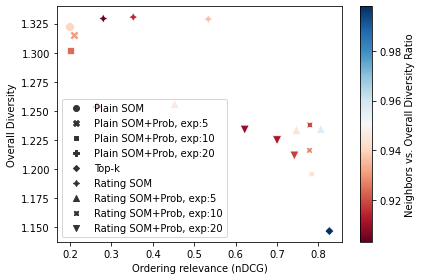

In [28]:
import seaborn as sns
from matplotlib import pyplot as plt

ax = sns.scatterplot(x=meanResReduced.nDCG.values, y=meanResReduced.meanOverallDiversity.values, 
                hue=meanResReduced.neighborOverallRatio.values, 
                style = zip(meanResReduced.index.get_level_values(1),meanResReduced.index.get_level_values(3),meanResReduced.index.get_level_values(2)),
                palette='RdBu',s=80)

norm = plt.Normalize(meanRes.neighborOverallRatio.min(), meanRes.neighborOverallRatio.max())
#meanRes.neighborOverallRatio.min(), meanRes.neighborOverallRatio.max()
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
handles, labels = ax.get_legend_handles_labels()
labelsDict = {
   "('rating', 10, False)": "Rating SOM", 
    "('rating', 5, True)": "Rating SOM+Prob, exp:5", 
    "('rating', 10, True)": "Rating SOM+Prob, exp:10", 
    "('rating', 20, True)": "Rating SOM+Prob, exp:20", 
    "('normal', 10, False)": "Plain SOM", 
    "('normal', 5, True)": "Plain SOM+Prob, exp:5", 
    "('normal', 10, True)": "Plain SOM+Prob, exp:10", 
    "('normal', 20, True)": "Plain SOM+Prob, exp:20", 
    
    "('topk', 10, False)": "Top-k"     
}
lbls = [labelsDict.get(i,i) for i in labels[-9:]]
ax.legend(handles=handles[-9:], labels=lbls, loc=3)
ax.set_xlabel("Ordering relevance (nDCG)")
ax.set_ylabel("Overall Diversity")

ax.figure.colorbar(sm, label="Neighbors vs. Overall Diversity Ratio")
plt.tight_layout()
plt.savefig("VBS_noTriangle.png", dpi=300)

In [12]:
evalProc2 = pickle.load(open("pck/evalProcVBSf2_disptopk_triagTrue.pck", "rb"))
ratingsDF2 = pickle.load(open("pck/ratingsDFVBSf2_disptopk_triagTrue.pck", "rb"))
ratingsUnbDF2 = pickle.load(open("pck/ratingsUnbDFVBSf2_disptopk_triagTrue.pck", "rb"))
resultingIDXDF2 = pickle.load(open("pck/resultingIDXDFVBSf2_disptopk_triagTrue.pck", "rb"))


In [13]:
meanDistN, maxDistN = calculateNeighborsDiversity(resultingIDXDF2, evalProc2.pairwiseSampleDistances, evalProc2.SOM_dim)
resultingIDXDF2["meanNeighborDiversity"]  =  meanDistN 
resultingIDXDF2["maxNeighborDiversity"]  =  maxDistN 

meanDist, maxDist = calculateOverallDiversity(resultingIDXDF2, evalProc2.pairwiseSampleDistances, evalProc2.SOM_dim)
resultingIDXDF2["meanOverallDiversity"]  =  meanDist 
resultingIDXDF2["maxDiversity"]  =  maxDist 

resultingIDXDF2["nDCG"] = calculateNDCG(resultingIDXDF2, evalProc2.unbiasedRatings, evalProc2.use_triangular, evalProc2.SOM_dim)
resultingIDXDF2["neighborOverallRatio"] = resultingIDXDF2.meanNeighborDiversity / resultingIDXDF2.meanOverallDiversity
meanRes2 = resultingIDXDF2.groupby(["alpha","som_variant","use_prob_candidate_selection","exponent"])[["nDCG","meanOverallDiversity","meanNeighborDiversity"]].mean()
meanRes2["neighborOverallRatio"] = meanRes2.meanNeighborDiversity / meanRes2.meanOverallDiversity

idx = pd.IndexSlice
meanResReduced2 = meanRes2.loc[idx[:, ["normal","topk","rating"],:,:], :]
meanResReduced2 = meanResReduced2.drop(meanResReduced2.loc[idx[:, "topk",True,:],:].index)
meanResReduced2

<ipython-input-8-03bc8221dfd5>:67: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df2["d_"+str(i+1)+"_"+str(j+1)] = distances[data["r"+str(i+1)],data["r"+str(j+1)]]
<ipython-input-8-03bc8221dfd5>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df2["d_"+str(i+1)+"_"+str(j+1)] = distances[data["r"+str(i+1)],data["r"+str(j+1)]]


nDCG  \
alpha som_variant use_prob_candidate_selection exponent             
0.01  normal      False                        10        0.199587   
                  True                         5         0.210502   
                                               10        0.200902   
                                               20        0.264382   
      topk        False                        10        0.826294   
      rating      False                        10        0.260245   
                  True                         5         0.295835   
                                               10        0.708222   
                                               20        0.586526   
0.03  rating      False                        10        0.213218   
                  True                         5         0.522217   
                                               10        0.643513   
                                               20        0.480604   
0.10  rating      False                        10        0.192456   
                  True                         5         0.490519   
                                               10        0.443158   
                                               20        0.410681   

                                                         meanOverallDiversity  \
alpha som_variant use_prob_candidate_selection exponent                         
0.01  normal      False                        10                    1.322132   
                  True                         5                     1.314791   
                                               10                    1.301962   
                                               20                    1.253461   
      topk        False                        10                    1.146293   
      rating      False                        10                    1.326315   
                  True                         5                     1.277797   
                                               10                    1.264255   
                                               20                    1.240876   
0.03  rating      False                        10                    1.322426   
                  True                         5                     1.292314   
                                               10                    1.275581   
                                               20                    1.246666   
0.10  rating      False                        10                    1.321468   
                  True                         5                     1.302408   
                                               10                    1.291421   
                                               20                    1.251601   

                                                         meanNeighborDiversity  \
alpha som_variant use_prob_candidate_selection exponent                          
0.01  normal      False                        10                     1.243279   
                  True                         5                      1.223740   
                                               10                     1.202991   
                                               20                     1.133690   
      topk        False                        10                     1.143876   
      rating      False                        10                     1.200821   
                  True                         5                      1.160046   
                                               10                     1.152093   
                                               20                     1.124177   
0.03  rating      False                        10                     1.211512   
                  True                         5                      1.164219   
                                               10                     1.162984   
                                               20            

In [14]:
evalProc3 = pickle.load(open("pck/evalProcVBSf1_disptopk_triagTrue.pck", "rb"))
ratingsDF3 = pickle.load(open("pck/ratingsDFVBSf1_disptopk_triagTrue.pck", "rb"))
ratingsUnbDF3 = pickle.load(open("pck/ratingsUnbDFVBSf1_disptopk_triagTrue.pck", "rb"))
resultingIDXDF3 = pickle.load(open("pck/resultingIDXDFVBSf1_disptopk_triagTrue.pck", "rb"))


In [15]:
meanDistN, maxDistN = calculateNeighborsDiversity(resultingIDXDF3, evalProc3.pairwiseSampleDistances, evalProc3.SOM_dim)
resultingIDXDF3["meanNeighborDiversity"]  =  meanDistN 
resultingIDXDF3["maxNeighborDiversity"]  =  maxDistN 

meanDist, maxDist = calculateOverallDiversity(resultingIDXDF3, evalProc3.pairwiseSampleDistances, evalProc3.SOM_dim)
resultingIDXDF3["meanOverallDiversity"]  =  meanDist 
resultingIDXDF3["maxDiversity"]  =  maxDist 

resultingIDXDF3["nDCG"] = calculateNDCG(resultingIDXDF3, evalProc3.unbiasedRatings, evalProc3.use_triangular, evalProc3.SOM_dim)
resultingIDXDF3["neighborOverallRatio"] = resultingIDXDF3.meanNeighborDiversity / resultingIDXDF3.meanOverallDiversity
meanRes3 = resultingIDXDF3.groupby(["alpha","som_variant","use_prob_candidate_selection","exponent"])[["nDCG","meanOverallDiversity","meanNeighborDiversity"]].mean()
meanRes3["neighborOverallRatio"] = meanRes3.meanNeighborDiversity / meanRes3.meanOverallDiversity

idx = pd.IndexSlice
meanResReduced3 = meanRes3.loc[idx[:, ["normal","topk","rating"],:,:], :]
meanResReduced3 = meanResReduced3.drop(meanResReduced3.loc[idx[:, "topk",True,:],:].index)
meanResReduced3

<ipython-input-8-03bc8221dfd5>:67: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df2["d_"+str(i+1)+"_"+str(j+1)] = distances[data["r"+str(i+1)],data["r"+str(j+1)]]
<ipython-input-8-03bc8221dfd5>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df2["d_"+str(i+1)+"_"+str(j+1)] = distances[data["r"+str(i+1)],data["r"+str(j+1)]]


nDCG  \
alpha som_variant use_prob_candidate_selection exponent             
0.2   normal      False                        10        0.199587   
                  True                         5         0.210502   
                                               10        0.200902   
                                               20        0.264382   
      topk        False                        10        0.826294   
      rating      False                        10        0.162196   
                  True                         5         0.339597   
                                               10        0.364079   
                                               20        0.415229   
0.5   rating      False                        10        0.191998   
                  True                         5         0.233352   
                                               10        0.247309   
                                               20        0.309236   
0.9   rating      False                        10        0.188567   
                  True                         5         0.225542   
                                               10        0.221692   
                                               20        0.256889   

                                                         meanOverallDiversity  \
alpha som_variant use_prob_candidate_selection exponent                         
0.2   normal      False                        10                    1.322132   
                  True                         5                     1.314791   
                                               10                    1.301962   
                                               20                    1.253461   
      topk        False                        10                    1.146293   
      rating      False                        10                    1.321710   
                  True                         5                     1.305732   
                                               10                    1.295903   
                                               20                    1.251498   
0.5   rating      False                        10                    1.322501   
                  True                         5                     1.311036   
                                               10                    1.299753   
                                               20                    1.252042   
0.9   rating      False                        10                    1.322557   
                  True                         5                     1.313677   
                                               10                    1.303009   
                                               20                    1.254230   

                                                         meanNeighborDiversity  \
alpha som_variant use_prob_candidate_selection exponent                          
0.2   normal      False                        10                     1.243279   
                  True                         5                      1.223740   
                                               10                     1.202991   
                                               20                     1.133690   
      topk        False                        10                     1.143876   
      rating      False                        10                     1.231184   
                  True                         5                      1.201860   
                                               10                     1.192288   
                                               20                     1.131758   
0.5   rating      False                        10                     1.235384   
                  True                         5                      1.216983   
                                               10                     1.200809   
                                               20            

In [16]:
(meanResReduced.index.get_level_values(0).unique(),
 meanResReduced2.index.get_level_values(0).unique(),
 meanResReduced3.index.get_level_values(0).unique()
)

(Float64Index([0.0003, 0.001, 0.003], dtype='float64', name='alpha'),
 Float64Index([0.01, 0.03, 0.1], dtype='float64', name='alpha'),
 Float64Index([0.2, 0.5, 0.9], dtype='float64', name='alpha'))

In [17]:
meanResReducedMerged = meanResReduced.append(meanResReduced2).append(meanResReduced3)
meanResReducedMerged.sort_index(inplace=True)
meanResReducedMerged

nDCG  \
alpha  som_variant use_prob_candidate_selection exponent             
0.0003 normal      False                        10        0.199587   
                   True                         5         0.210502   
                                                10        0.200902   
                                                20        0.264382   
       rating      False                        10        0.533688   
                   True                         5         0.805602   
                                                10        0.783595   
                                                20        0.741783   
       topk        False                        10        0.826294   
0.0010 rating      False                        10        0.352576   
                   True                         5         0.746656   
                                                10        0.778309   
                                                20        0.699885   
0.0030 rating      False                        10        0.280231   
                   True                         5         0.452640   
                                                10        0.779164   
                                                20        0.621758   
0.0100 normal      False                        10        0.199587   
                   True                         5         0.210502   
                                                10        0.200902   
                                                20        0.264382   
       rating      False                        10        0.260245   
                   True                         5         0.295835   
                                                10        0.708222   
                                                20        0.586526   
       topk        False                        10        0.826294   
0.0300 rating      False                        10        0.213218   
                   True                         5         0.522217   
                                                10        0.643513   
                                                20        0.480604   
0.1000 rating      False                        10        0.192456   
                   True                         5         0.490519   
                                                10        0.443158   
                                                20        0.410681   
0.2000 normal      False                        10        0.199587   
                   True                         5         0.210502   
                                                10        0.200902   
                                                20        0.264382   
       rating      False                        10        0.162196   
                   True                         5         0.339597   
                                                10        0.364079   
                                                20        0.415229   
       topk        False                        10        0.826294   
0.5000 rating      False                        10        0.191998   
                   True                         5         0.233352   
                                                10        0.247309   
                                                20        0.309236   
0.9000 rating      False                        10        0.188567   
                   True                         5         0.225542   
                                                10        0.221692   
                                                20        0.256889   

                                                          meanOverallDiversity  \
alpha  som_variant use_prob_candidate_selection exponent                         
0.0003 normal      False                        10                    1.322132   
                   True                         5                     1.314791   
                       

In [18]:
meanResReducedMerged = meanResReducedMerged.drop(meanResReducedMerged.loc[idx[:,:,:, 5],:].index)
meanResReducedMerged = meanResReducedMerged.drop(meanResReducedMerged.loc[idx[[0.01,0.2], ["normal","topk"],:,:],:].index)

In [19]:
meanResReducedMerged.index.get_level_values(0).unique()

Float64Index([0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.2, 0.5, 0.9], dtype='float64', name='alpha')

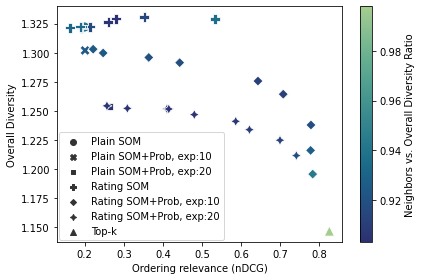

In [29]:
import seaborn as sns
from matplotlib import pyplot as plt

ax = sns.scatterplot(x=meanResReducedMerged.nDCG.values, y=meanResReducedMerged.meanOverallDiversity.values, 
                hue=meanResReducedMerged.neighborOverallRatio.values, 
                style = zip(meanResReducedMerged.index.get_level_values(1),meanResReducedMerged.index.get_level_values(3),meanResReducedMerged.index.get_level_values(2)),
                palette='crest_r',s=100)

norm = plt.Normalize(meanResReducedMerged.neighborOverallRatio.min(), meanResReducedMerged.neighborOverallRatio.max())
#meanRes.neighborOverallRatio.min(), meanRes.neighborOverallRatio.max()
sm = plt.cm.ScalarMappable(cmap="crest_r", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
handles, labels = ax.get_legend_handles_labels()
labelsDict = {
   "('rating', 10, False)": "Rating SOM", 
    "('rating', 5, True)": "Rating SOM+Prob, exp:5", 
    "('rating', 10, True)": "Rating SOM+Prob, exp:10", 
    "('rating', 20, True)": "Rating SOM+Prob, exp:20", 
    "('normal', 10, False)": "Plain SOM", 
    "('normal', 5, True)": "Plain SOM+Prob, exp:5", 
    "('normal', 10, True)": "Plain SOM+Prob, exp:10", 
    "('normal', 20, True)": "Plain SOM+Prob, exp:20", 
    
    "('topk', 10, False)": "Top-k"     
}
lbls = [labelsDict.get(i,i) for i in labels[-7:]]
ax.legend(handles=handles[-7:], labels=lbls, bbox_to_anchor=(-0.01,-0.015), loc=3)
ax.set_xlabel("Ordering relevance (nDCG)")
ax.set_ylabel("Overall Diversity")

ax.figure.colorbar(sm, label="Neighbors vs. Overall Diversity Ratio")
plt.tight_layout()
plt.savefig("VBS_mergedTriangle.png", dpi=300)